# Text generation models evaluation

#### This notebook evaluates several LLMs from Bedrock, HuggingFace, Jumpstart, Bedrock finetuned models
#### Instance type used for the evaluation - ml.g4dn.2xlarge or m5.2xlarge, python 3.10
#### The metrics evaluated are N-gram matching-based (ROUGE, METEOR) and sematic-based (BERTScore) from FMEval library (can be further customized)
#### The datasets used is TweetSumm (EMNLP 21) 

In [4]:
%load_ext autoreload
%autoreload 2

OUTPUT_BUCKET =  # the path to the S3 bucket where the output zip will be uploaded

MODELS_TO_EVAL = [] # if empty list will evaluate all the models available. For specific models, mention their ids from the list below, for example ["anthropic.claude-v2:1", "amazon.titan-text-lite-v1"]

OUTPUT_FILENAME = "test_samples_result" # the name of the output zip that will contain the eval results
### Metrics to calc
# BARTscore - for more details https://github.com/neulab/BARTScore/blob/main/README.md
CALC_BARTSCORE = True
PATH_TO_FINETUNED_BART = "" # if left empty will use vanilla BART. If you wish to load the finetuned BART, go to BARTscore's github, download the bart_score.pth (appear on the README) and provide the path here

In [5]:
!pip install --upgrade pip --quiet
!pip install -r requirements.txt --quiet

### OPEN AI API key
This is relevant if you'll be using models from OpenAI

- Create a new file called `utils/key.py` in your project directory to store your API key.
- Do **not** commit `key.py` to source control, as it contains sensitive information. **Add `*key.py` to `.gitgnore`.** Review [this information about API safety](https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety).
- Go to your OpenAI account and navigate to "[View API keys](https://platform.openai.com/account/api-keys)."
- Select "Create new secret key."
- Copy the key and insert it into your file `utils/key.py` like this:
```
OPENAI_API_KEY = 'sk-actualLongKeyGoesHere123'
```
- Save the changes

In [6]:
from utils.key import OPENAI_API_KEY

## Define bucket config

In [7]:
import json
from pathlib import Path
import boto3
import glob
import shutil
import os
from os import listdir

from fmeval.model_runners.bedrock_model_runner import BedrockModelRunner
from fmeval.model_runners.sm_jumpstart_model_runner import JumpStartModelRunner

from utils.model_runners.gpt_model_runner import GPTModelConfig, GPTModelRunner
from utils.tweetsumm_data_creator import create_train_test_files
from utils.dashboard_creators.output_viewer_creator import create_response_output_view
from utils.dashboard_creators.comparative_dashboard_creator import create_comparive_dashboard
from utils.dashboard_creators.data_stats_viewer_creator import create_data_stats_view
from utils.dashboard_creators.data_preview_viewer import create_data_preview_view
from utils.dashboard_creators.main_html_creator import create_main_html
from utils.metrics.bart_score import calculate_bartscore

RESULT_FOLDER = "/tmp/final_result"
if os.path.exists(RESULT_FOLDER):
    shutil.rmtree(RESULT_FOLDER)
os.mkdir(RESULT_FOLDER)

TMP_JSON_FILES = "/tmp/jsonl_model_files"
if os.path.exists(TMP_JSON_FILES):
    shutil.rmtree(TMP_JSON_FILES)
os.mkdir(TMP_JSON_FILES)

TMP_DATASET_FILES = "/tmp/dataset_files"
if os.path.exists(TMP_DATASET_FILES):
    shutil.rmtree(TMP_DATASET_FILES)
os.mkdir(TMP_DATASET_FILES)

RESULT_HTML_FOLDER = RESULT_FOLDER + "/html_files"
if os.path.exists(RESULT_HTML_FOLDER):
    shutil.rmtree(RESULT_HTML_FOLDER)
os.mkdir(RESULT_HTML_FOLDER)

RESULT_IMG_FOLDER = RESULT_FOLDER + "/imgs"
if os.path.exists(RESULT_IMG_FOLDER):
    shutil.rmtree(RESULT_IMG_FOLDER)
os.mkdir(RESULT_IMG_FOLDER)

TEST_FILE_PATH = create_train_test_files(TMP_DATASET_FILES) # creating train and test files 
print(TEST_FILE_PATH)

os.environ["PARALLELIZATION_FACTOR"] = "1" # will use a single workder for FMEval

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


/home/sagemaker-user/fm-leaderboarder/.venv/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for Salesforce/dialogstudio contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Salesforce/dialogstudio
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Test set size: 220
Train set size: 879
Created training set file that can be used for Bedrock finetuning under the folder: /tmp/dataset_files/bedrock_train_tweetsumm.jsonl
/tmp/dataset_files/test_tweetsumm_modified.jsonl


## Load models and create ModelRunner objects

In [8]:
# Bedrock models

models_dict = {
    "random" : { 
        "model_id" : "amazon.titan-text-lite-v1", 
        "platform" : "bedrock",
        "output" : "results[0].outputText", 
        "content_template" : "{\"inputText\": $prompt, \"textGenerationConfig\":  {\"maxTokenCount\": 100, \"stopSequences\": [], \"temperature\": 1.0, \"topP\": 1.0}}",
        "prompt_template" : "Please ignore the following blob of text and create an unrelated text of around 2 sentences\n $feature\n"
    },
    "anthropic.claude-v2:1" : { 
        "model_id" : "anthropic.claude-v2:1", 
        "platform" : "bedrock",
        "output" : "completion", 
        "content_template" : "{\"prompt\": $prompt, \"max_tokens_to_sample\": 100}",
        "prompt_template" : "Human: Belowasd is a dialog between a customer and an agent. Please provide a short and concise summary of the conversation. The summary should be short and include a single sentence describing the customer's complaint or request, and single sentence of the agent's response or action. Please write the summary in a human readable format. Specify important and relevant amounts, dates and locations inside the summary.\nHere is the dialog: $feature\n\nAssistant:"
    },
    "anthropic.claude-v2" : { 
        "model_id" : "anthropic.claude-v2", 
        "platform" : "bedrock",
        "output" : "completion", 
        "content_template" : "{\"prompt\": $prompt, \"max_tokens_to_sample\": 100}",
        "prompt_template" : "Human: Below is a dialog between a customer and an agent. Please provide a short and concise summary of the conversation. The summary should be short and include a single sentence describing the customer's complaint or request, and single sentence of the agent's response or action. Please write the summary in a human readable format. Specify important and relevant amounts, dates and locations inside the summary.\nHere is the dialog: $feature\n\nAssistant:"
    },
    "anthropic.claude-instant-v1" : { 
        "model_id" : "anthropic.claude-instant-v1", 
        "platform" : "bedrock",
        "output" : "completion", 
        "content_template" : "{\"prompt\": $prompt, \"max_tokens_to_sample\": 100}",
        "prompt_template" : "Human: Below is a dialog between a customer and an agent. Please provide a short and concise summary of the conversation. The summary should be short and include a single sentence describing the customer's complaint or request, and single sentence of the agent's response or action. Please write the summary in a human readable format. Start you answer directly with the summary without any additional prefix.\n Specify important and relevant amounts, dates and locations inside the summary. Here is the dialog: $feature\n\nAssistant:"
    },
    "amazon.titan-text-lite-v1" : { 
        "model_id" : "amazon.titan-text-lite-v1", 
        "platform" : "bedrock",
        "output" : "results[0].outputText", 
        "content_template" : "{\"inputText\": $prompt, \"textGenerationConfig\":  {\"maxTokenCount\": 100, \"stopSequences\": [], \"temperature\": 1.0, \"topP\": 1.0}}",
        "prompt_template" : "Please provide a short and concise summary of the conversation below. The summary should be short and include a single sentence describing the customer's complaint or request, and single sentence of the agent's response or action. Do not include any additional information that does not appear in the dialog.  Specify important and relevant amounts, dates and locations inside the sentences of the summary. Here is the dialog:\n$feature\n\nsummary:\n"
    },
    "amazon.titan-text-express-v1" :{ 
        "model_id" : "amazon.titan-text-express-v1", 
        "platform" : "bedrock",
        "output" : "results[0].outputText", 
        "content_template" : "{\"inputText\": $prompt, \"textGenerationConfig\": {\"maxTokenCount\": 100, \"stopSequences\": [], \"temperature\": 1.0, \"topP\": 1.0}}",
        "prompt_template" : "Please provide a short and concise summary of the conversation below that includes a summary of both the user and the agent.  Specify important and relevant amounts, dates and locations inside the sentences of the summary. Here is the dialog:\n $feature\n\nsummary:\n"
    },
    "amazon.titan-text-lite-v1-one-shot" : { 
        "model_id" : "amazon.titan-text-lite-v1", 
        "platform" : "bedrock",
        "output" : "results[0].outputText", 
        "content_template" : "{\"inputText\": $prompt, \"textGenerationConfig\":  {\"maxTokenCount\": 100, \"stopSequences\": [], \"temperature\": 1.0, \"topP\": 1.0}}",
        "prompt_template" : "[INST]Please provide a short and concise summary of the conversation below that includes a summary of both the user and the agent.  Specify important and relevant amounts, dates and locations inside the sentences of the summary. \n Example Transcript:\n user: bought a celcus tv from your Finchley store last year in December and it stopped working yesterday - can you repair it or change Your cctv recording from the date we bought it - agent: Can you confirm did you pay cash or card for the telvision? We accept credit/debit card statements as a proof of purchase. Steven user: Yes. I paid by card, I think there were other things I bought with the tv as well , but I remember the price of the television was 175 Actually, I just checked my bank statements and I bought the tv in January 2017 and not dec 2016 and paid for it by card - 175 agent: We would use the bank statements transaction ID to match our till receipts. If you return the television with your credit/debit card...1/2 ...statement our in store colleagues will advise you further. Steven 2/2 user: Great! Thank you. One last question, Ive recycled the Tvs box - is it rwqur Required** agent: As long as you've got proof of purchase you'll be fine Dimitar! Ewan.\n Summary: Customer is asking to repair or change the television which is not working. Agent updated to return the television with their credit/debit card.\n\n [/INST] </s><s>[INST]\n Transcript:\n $feature [/INST]\n Summary:"
    },
    "meta.llama2-13b-chat-v1-one-shot" :{ 
        "model_id" : "meta.llama2-13b-chat-v1", 
        "platform" : "bedrock",
        "output" : "generation", 
        "content_template" : "{\"prompt\": $prompt, \"max_gen_len\": 100, \"top_p\": 1, \"temperature\": 1.0}",
        "prompt_template" : "[INST] <<SYS>> Please provide a short and concise summary of the conversation below that includes a summary of both the user and the agent.  Specify important and relevant amounts, dates and locations inside the sentences of the summary.<</SYS> \n Example Transcript:\n user: bought a celcus tv from your Finchley store last year in December and it stopped working yesterday - can you repair it or change Your cctv recording from the date we bought it - agent: Can you confirm did you pay cash or card for the telvision? We accept credit/debit card statements as a proof of purchase. Steven user: Yes. I paid by card, I think there were other things I bought with the tv as well , but I remember the price of the television was 175 Actually, I just checked my bank statements and I bought the tv in January 2017 and not dec 2016 and paid for it by card - 175 agent: We would use the bank statements transaction ID to match our till receipts. If you return the television with your credit/debit card...1/2 ...statement our in store colleagues will advise you further. Steven 2/2 user: Great! Thank you. One last question, Ive recycled the Tvs box - is it rwqur Required** agent: As long as you've got proof of purchase you'll be fine Dimitar! Ewan.\n Summary: Customer is asking to repair or change the television which is not working. Agent updated to return the television with their credit/debit card.\n\n [/INST] </s><s>[INST]\n Transcript:\n $feature [/INST] Summary:"
    },
    "cohere.command-light-text-v14-one-shot" :{ 
        "model_id" : "cohere.command-light-text-v14", 
        "platform" : "bedrock",
        "output" : "generations[0].text", 
        "content_template" : "{\"prompt\": $prompt, \"max_tokens\": 100}",
        "prompt_template" : "Please provide a short and concise summary of the conversation below that includes a summary of both the user and the agent.  Specify important and relevant amounts, dates and locations inside the sentences of the summary.\n\n Example Transcript:\n user: bought a celcus tv from your Finchley store last year in December and it stopped working yesterday - can you repair it or change Your cctv recording from the date we bought it - agent: Can you confirm did you pay cash or card for the telvision? We accept credit/debit card statements as a proof of purchase. Steven user: Yes. I paid by card, I think there were other things I bought with the tv as well , but I remember the price of the television was 175 Actually, I just checked my bank statements and I bought the tv in January 2017 and not dec 2016 and paid for it by card - 175 agent: We would use the bank statements transaction ID to match our till receipts. If you return the television with your credit/debit card...1/2 ...statement our in store colleagues will advise you further. Steven 2/2 user: Great! Thank you. One last question, Ive recycled the Tvs box - is it rwqur Required** agent: As long as you've got proof of purchase you'll be fine Dimitar! Ewan.\n Summary: Customer is asking to repair or change the television which is not working. Agent updated to return the television with their credit/debit card.\n\nTranscript:\n $feature\n Summary:"
    },
    "amazon.titan-text-express-v1-one-shot" :{ 
        "model_id" : "amazon.titan-text-express-v1", 
        "platform" : "bedrock",
        "output" : "results[0].outputText", 
        "content_template" : "{\"inputText\": $prompt, \"textGenerationConfig\": {\"maxTokenCount\": 100, \"stopSequences\": [], \"temperature\": 1.0, \"topP\": 1.0}}",
        "prompt_template" : "Please provide a short and concise summary of the conversation below that includes a summary of both the user and the agent.  Specify important and relevant amounts, dates and locations inside the sentences of the summary.\n\n Example Transcript:\n user: bought a celcus tv from your Finchley store last year in December and it stopped working yesterday - can you repair it or change Your cctv recording from the date we bought it - agent: Can you confirm did you pay cash or card for the telvision? We accept credit/debit card statements as a proof of purchase. Steven user: Yes. I paid by card, I think there were other things I bought with the tv as well , but I remember the price of the television was 175 Actually, I just checked my bank statements and I bought the tv in January 2017 and not dec 2016 and paid for it by card - 175 agent: We would use the bank statements transaction ID to match our till receipts. If you return the television with your credit/debit card...1/2 ...statement our in store colleagues will advise you further. Steven 2/2 user: Great! Thank you. One last question, Ive recycled the Tvs box - is it rwqur Required** agent: As long as you've got proof of purchase you'll be fine Dimitar! Ewan.\n Summary: Customer is asking to repair or change the television which is not working. Agent updated to return the television with their credit/debit card.\n\nTranscript:\n $feature\n Summary:"
    },
    "cohere.command-light-text-v14" :{ 
        "model_id" : "cohere.command-light-text-v14", 
        "platform" : "bedrock",
        "output" : "generations[0].text", 
        "content_template" : "{\"prompt\": $prompt, \"max_tokens\": 100}",
        "prompt_template" : "Please provide a short and concise summary of the conversation below that includes a summary of both the user and the agent.  Specify important and relevant amounts, dates and locations inside the sentences of the summary. Here is the dialog:\n $feature\n\nsummary:\n"
    },
    "meta.llama2-13b-chat-v1" :{ 
        "model_id" : "meta.llama2-13b-chat-v1", 
        "platform" : "bedrock",
        "output" : "generation", 
        "content_template" : "{\"prompt\": $prompt, \"max_gen_len\": 100, \"top_p\": 1, \"temperature\": 1.0}",
        "prompt_template" : "[INST]Please provide a short and concise summary of the conversation below that includes a summary of both the user and the agent.  Specify important and relevant amounts, dates and locations inside the sentences of the summary. Here is the dialog:[/INST]\n Transcript\n $feature \n\n Summary:\n"
    },
    "gpt.3.5-turbu-0125" :{ 
        "model_id" : "gpt-3.5-turbo-0125", 
        "api_key" : OPENAI_API_KEY,
        "platform" : "openai",
        "temperature" : 1,
        "top_p" : 1,
        "max_tokens" : 100,
        "prompt_template" : "Please provide a short and concise summary of the conversation below that includes a summary of both the user and the agent.  Specify important and relevant amounts, dates and locations inside the sentences of the summary.\n Transcript:\n $feature \n Summary:\n"
    }
}


In [26]:
# Bedrock models

models_dict = {
    "random" : { 
        "model_id" : "amazon.titan-text-lite-v1", 
        "platform" : "bedrock",
        "output" : "results[0].outputText", 
        "content_template" : "{\"inputText\": $prompt, \"textGenerationConfig\":  {\"maxTokenCount\": 100, \"stopSequences\": [], \"temperature\": 1.0, \"topP\": 1.0}}",
        "prompt_template" : "Please ignore the following blob of text and create an unrelated text of around 2 sentences\n $feature\n"
    },
    "anthropic.claude-instant-v1" : { 
        "model_id" : "anthropic.claude-instant-v1", 
        "platform" : "bedrock",
        "output" : "completion", 
        "content_template" : "{\"prompt\": $prompt, \"max_tokens_to_sample\": 100}",
        "prompt_template" : "Human: Below is a dialog between a customer and an agent. Please provide a short and concise summary of the conversation. The summary should be short and include a single sentence describing the customer's complaint or request, and single sentence of the agent's response or action. Please write the summary in a human readable format. Start you answer directly with the summary without any additional prefix.\n Specify important and relevant amounts, dates and locations inside the summary. Here is the dialog: $feature\n\nAssistant:"
    },
}

## Adding your own custom models
In case you wish to add custom model, simply create custom model runner. For example, see custom model runner which wraps GPT-3.5 in the folder utils/model_runners/gpt_model_runner.py 


## Adding finetuned models
In case you wish to add Bedrock finetuned model: 
1. First finetune a model (for details on finetuning on Berdrock visit https://aws.amazon.com/blogs/aws/customize-models-in-amazon-bedrock-with-your-own-data-using-fine-tuning-and-continued-pre-training/).
2. Once training completed, from Bedrock copy the ARN from Bedrock 'provisioned throughput' dashboard and paste it as the model_id. A finetuning training set is provided. For more details see documentation
3. Add to the model_dict in the cell above the configuration of your finetuned model as follows:

<code>
{
    "finetuned_amazon.titan-text-lite-v1" : {
    "platform":"bedrock",
    "model_id": "arn:aws:bedrock:us-east-1:333333333:provisioned-model/879asd6s75",
    "output": "results[0].outputText",
    "content_template": {"inputText": $prompt, "textGenerationConfig":  {"maxTokenCount": 100, "stopSequences": [], "temperature": 1.0, "topP": 1.0}},
    "prompt_template": "YOUR PROMPT HERE"
    }
}
</code>


## Adding Jumpstart models
Example for evaluation Mistral-7B-Instruct from Jumpstart:
1. Go to Jumpstart (press home button -> Jumpstart)
2. Search in the bar for Mistral-7B-Instruct
3. Click deploy from the model card (don't forget to close the endpoint once you done from SageMaker->inference endpoints)
4. Add the following to the models list
<code>
{
    "platform":"jumpstart",
    "model_id": "huggingface-llm-mistral-7b-instruct",
    "endpoint_name": "jumpstart-dft-hf-llm-mistral-7b-instruct",
    "model_version": "*",
    "output": "[0].generated_text",
    "content_template":"{\"inputs\": $prompt, \"parameters\": {\"do_sample\": false, \"max_new_tokens\": 100}}",
    "prompt_template": "YOUR PROMPT HERE"
}
</code>


## Creating ModelRunner

In [27]:
def get_models_to_eval():
    if len(MODELS_TO_EVAL) == 0:
        return list(models_dict.keys())
    return MODELS_TO_EVAL

models = dict()        
for fm in get_models_to_eval():  
    
    data = models_dict[fm]
    platform = data['platform']
    
    if platform == "bedrock":
        runner = BedrockModelRunner(model_id=data["model_id"], output=data["output"], content_template=data["content_template"].replace("'","\""))
    elif platform == "jumpstart":
        runner = JumpStartModelRunner(endpoint_name=data["endpoint_name"], model_id=data["model_id"], model_version=data["model_version"], output=data["output"].replace("'","\""), content_template=data["content_template"].replace("'","\""))
    elif platform == "openai":
        if OPENAI_API_KEY != "":
            runner = GPTModelRunner(GPTModelConfig(model_id=data["model_id"], api_key=data["api_key"], temperature=data["temperature"], top_p=data["top_p"], max_tokens=data["max_tokens"]))
        else:
            print("Cannot run GPT without an API key")
        
    models[fm] = { "model_runner": runner, "prompt_template": data["prompt_template"]}


## Evaluation run
Evaluating METEOR, ROUGE, and BERTscore using FMEval library (https://github.com/aws/fmeval). This library is also used by Bedrock when finetuning or evaluating models.

#### Note - if while running this cell you encounter the message - "Error displaying widget: model not found" in the evaluation phase...", simply ignore it. It relates to the UI and does not effect the evaluation.

In [28]:
from fmeval.data_loaders.data_config import DataConfig
from fmeval.constants import MIME_TYPE_JSONLINES
from fmeval.eval_algorithms.summarization_accuracy import SummarizationAccuracy, SummarizationAccuracyConfig
import pandas as pd
import os

models_scores = dict()
for model_id in get_models_to_eval():
    print(f"### Starting model {model_id} evaluation")
    model = models[model_id]
    config = DataConfig(
        dataset_name=f"data",
        dataset_uri=TEST_FILE_PATH,
        dataset_mime_type=MIME_TYPE_JSONLINES,
        model_input_location="document",
        target_output_location="summary"
    )

    model_runner = model['model_runner']
    eval_algo = SummarizationAccuracy(SummarizationAccuracyConfig())
    eval_output = eval_algo.evaluate(model=model_runner, 
                                     dataset_config=config,
                                     prompt_template=model["prompt_template"],
                                     num_records=10,
                                     save=True)

    scores = dict()
    for i in eval_output[0].dataset_scores:
        scores[i.name] = i.value
    
    models_scores[model_id] = scores

    shutil.move('/tmp/eval_results/summarization_accuracy_data.jsonl', f'{TMP_JSON_FILES}/{model_id}_metrics.jsonl')


### Starting model random evaluation


[nltk_data] Downloading package wordnet to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/sagemaker-user/fm-leaderboarder/.venv/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by promote_options='default'.
  return transform_pyarrow.concat(tables)
2024-03-13 13:51:00,032	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition]
2024-03-13 13:51:00,033	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:51:00,033	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:51:00,095	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[Map(_generate_prompt_column)]
2024-03-13 13:51:00,096	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:51:00,097	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:51:00,143	WARNING util.py:546 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-03-13 13:51:00,147	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[Map(ModelRunnerWrapper)]
2024-03-13 13:51:00,148	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:51:00,149	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2024-03-13 13:51:00,168	INFO actor_pool_map_operator.py:114 -- Map(ModelR

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:51:12,195	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[Map(_generate_eval_scores)]
2024-03-13 13:51:12,195	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:51:12,196	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:51:26,075	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]
2024-03-13 13:51:26,076	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:51:26,077	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Aggregate 1:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:51:26,140	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]
2024-03-13 13:51:26,141	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:51:26,142	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Aggregate 1:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:51:26,202	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]
2024-03-13 13:51:26,203	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:51:26,204	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Aggregate 1:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:51:26,264	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[Map(<lambda>)]
2024-03-13 13:51:26,264	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:51:26,265	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:51:26,309	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[Map(<lambda>)]
2024-03-13 13:51:26,310	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:51:26,310	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

/home/sagemaker-user/fm-leaderboarder/.venv/lib/python3.10/site-packages/ray/data/_internal/pandas_block.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(items[0], TensorArrayElement):
/home/sagemaker-user/fm-leaderboarder/.venv/lib/python3.10/site-packages/ray/data/_internal/pandas_block.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return items[0]
/home/sagemaker-user/fm-leaderboarder/.venv/lib/python3.10/site-packages/ray/data/_internal/pandas_block.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

### Starting model anthropic.claude-instant-v1 evaluation


Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

Read progress 0:   0%|          | 0/1 [00:00<?, ?it/s]

/home/sagemaker-user/fm-leaderboarder/.venv/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by promote_options='default'.
  return transform_pyarrow.concat(tables)
2024-03-13 13:51:26,470	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Repartition]
2024-03-13 13:51:26,471	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:51:26,471	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Repartition 1:   0%|          | 0/5 [00:00<?, ?it/s]

Split Repartition 2:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:51:26,562	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[Map(_generate_prompt_column)]
2024-03-13 13:51:26,562	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:51:26,563	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:51:26,616	WARNING util.py:546 -- The argument ``compute`` is deprecated in Ray 2.9. Please specify argument ``concurrency`` instead. For more information, see https://docs.ray.io/en/master/data/transforming-data.html#stateful-transforms.
2024-03-13 13:51:26,621	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[Map(ModelRunnerWrapper)]
2024-03-13 13:51:26,622	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:51:26,623	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2024-03-13 13:51:26,645	INFO actor_pool_map_operator.py:114 -- Map(ModelR

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:51:48,228	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[Map(_generate_eval_scores)]
2024-03-13 13:51:48,228	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:51:48,229	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:52:08,904	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]
2024-03-13 13:52:08,905	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:52:08,905	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Aggregate 1:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:52:08,971	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]
2024-03-13 13:52:08,971	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:52:08,972	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Aggregate 1:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:52:09,031	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[Aggregate] -> LimitOperator[limit=1]
2024-03-13 13:52:09,031	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:52:09,032	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


- Aggregate 1:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/5 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/5 [00:00<?, ?it/s]

Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:52:09,092	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[Map(<lambda>)]
2024-03-13 13:52:09,093	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:52:09,094	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

2024-03-13 13:52:09,137	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[Map(<lambda>)]
2024-03-13 13:52:09,137	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-03-13 13:52:09,138	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/5 [00:00<?, ?it/s]

/home/sagemaker-user/fm-leaderboarder/.venv/lib/python3.10/site-packages/ray/data/_internal/pandas_block.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(items[0], TensorArrayElement):
/home/sagemaker-user/fm-leaderboarder/.venv/lib/python3.10/site-packages/ray/data/_internal/pandas_block.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return items[0]
/home/sagemaker-user/fm-leaderboarder/.venv/lib/python3.10/site-packages/ray/data/_internal/pandas_block.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as

## Calculate BARTscore

In [29]:
if CALC_BARTSCORE:
    calculate_bartscore(TMP_JSON_FILES, models_scores, PATH_TO_FINETUNED_BART)

Evaluating random model
Processed 10/10 samples.
Evaluating anthropic.claude-instant-v1 model
Processed 10/10 samples.


## Construct response HTML

Generated /tmp/final_result/index.html


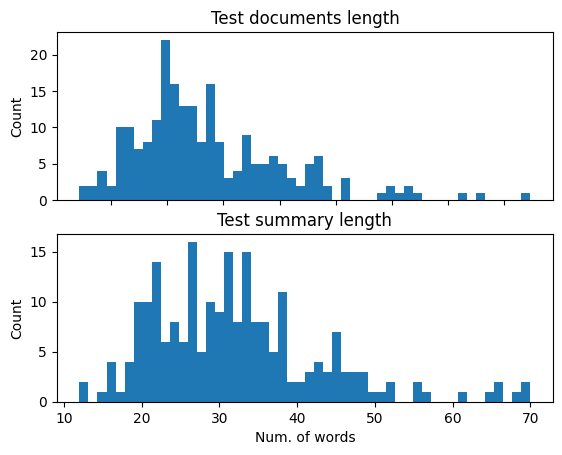

In [30]:
create_response_output_view(RESULT_HTML_FOLDER, TMP_JSON_FILES, models_scores)
create_comparive_dashboard(RESULT_HTML_FOLDER, TMP_JSON_FILES)
create_data_stats_view(TEST_FILE_PATH, RESULT_IMG_FOLDER)
create_data_preview_view(TEST_FILE_PATH, RESULT_HTML_FOLDER)
main_html_filename = create_main_html(RESULT_FOLDER, models_scores)
print(f"Generated {main_html_filename}")

## Upload to S3

In [31]:
from datetime import datetime
today = datetime.now()

d1 = today.strftime("%d-%m-%Y_%H-%M-%S") # dd/mm/YY
shutil.make_archive(f"/tmp/{str(d1)}", 'zip', "/tmp/final_result")

s3 = boto3.resource('s3')
s3_key = f"{OUTPUT_FILENAME}_{str(d1)}.zip"
s3.meta.client.upload_file(f"/tmp/{str(d1)}.zip", OUTPUT_BUCKET, s3_key)
print(f'To view the results on your local computer copy-paste these commands:\n\
    aws s3 cp s3://{OUTPUT_BUCKET}/{s3_key} /tmp/{s3_key}\n\
    cd /tmp\n\
    unzip -d {s3_key.replace(".zip","")} {s3_key}\n\
    open /tmp/{s3_key.replace(".zip","")}/index.html')

To view the results on your local computer copy-paste these commands:
    aws s3 cp s3://gili-dev/test_samples_result_13-03-2024_13-52-16.zip /tmp/test_samples_result_13-03-2024_13-52-16.zip
    cd /tmp
    unzip -d test_samples_result_13-03-2024_13-52-16 test_samples_result_13-03-2024_13-52-16.zip
    open /tmp/test_samples_result_13-03-2024_13-52-16/index.html
